In [1]:
import re, sys
import pandas as pd
import numpy as np
import json
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import rdChemReactions, AllChem, Draw, PandasTools
RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings('ignore')

In [2]:
def remove_bb_smi_label(smi):
    return re.sub(r"\[\d{2}\*\]", "[*]", smi)

#### Extract

In [3]:
with open("../data/raw/DORA_Lactam_mols_bbs.json", "r") as f:
    mols = json.load(f)
with open("../data/raw/DORA_Lactam_bbs.json", "r") as f:
    bbs = json.load(f)
    
df_mols = pd.json_normalize(mols)
df_bbs = pd.json_normalize(bbs)

#### Transform

In [4]:
df_bbs = df_bbs[["bb_smi", "bb_id"]]
df_mols = df_mols[["mol_smi", "mol_id", "A_id", "B_id", "C_id"]]

for col in ["A", "B", "C"]:
    df_mols = df_mols.merge(
        df_bbs,
        left_on=f"{col}_id",
        right_on="bb_id",
        how="left"
    ).rename(columns={"bb_smi": f"{col}_smi"}).drop(columns=["bb_id"])

df_mols = df_mols.dropna(subset=["A_id", "B_id", "C_id"])

In [5]:
for col in ["A_smi", "B_smi", "C_smi"]:
    df_mols[col] = df_mols[col].apply(remove_bb_smi_label)
    
df_mols['bbs_smi'] = df_mols['A_smi'] + '.' + df_mols['B_smi'] + '.' + df_mols['C_smi']

#### Save

In [6]:
df_mols.to_pickle("../data/transformed/df_mols_ready.pkl")

#### Augment

In [7]:
from rdkit import Chem
import random

def augment_smiles(smiles, num_aug=5):
    """
    Generate augmented SMILES strings for the same molecule.
    
    Args:
        smiles (str): input SMILES
        num_aug (int): number of augmented SMILES to generate
    
    Returns:
        list of str: augmented SMILES (non-canonical)
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    
    aug_smiles = set()
    for _ in range(num_aug):
        # Use random atom ordering to generate non-canonical SMILES
        aug = Chem.MolToSmiles(mol, doRandom=True)
        aug_smiles.add(aug)
    
    return list(aug_smiles)

In [8]:
smi = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"
print("Original:", smi)
print("Augmented:", augment_smiles(smi, num_aug=10))

Original: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
Augmented: ['s1c2cc(ccc2nc1S(N)(=O)=O)OCC', 'c12ccc(cc2sc(S(N)(=O)=O)n1)OCC', 'c1c(OCC)cc2c(c1)nc(S(=O)(N)=O)s2', 'n1c(sc2c1ccc(OCC)c2)S(N)(=O)=O', 'c1(OCC)cc2c(cc1)nc(S(=O)(=O)N)s2', 'c12sc(nc2ccc(OCC)c1)S(=O)(N)=O', 'c12nc(S(N)(=O)=O)sc1cc(OCC)cc2', 'S(=O)(=O)(c1nc2ccc(cc2s1)OCC)N', 'c1c2c(nc(S(N)(=O)=O)s2)ccc1OCC', 'c12nc(sc2cc(OCC)cc1)S(=O)(=O)N']


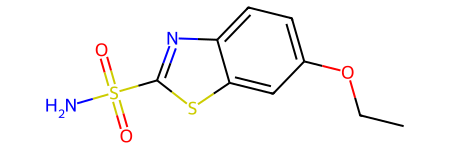

In [9]:
Chem.MolFromSmiles('c1c2c(nc(S(N)(=O)=O)s2)ccc1OCC')

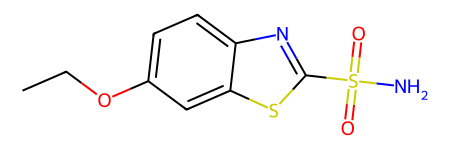

In [10]:
Chem.MolFromSmiles(smi)